In [2]:
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
from pytorch3d.io import load_objs_as_meshes, load_obj
import math

2023-11-02 17:29:03.437306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 17:29:03.506777: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 17:29:03.852758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aaron/miniconda3/envs/mp/lib/python3.10/site-packages/cv2/../../lib64::/usr/local/cuda-11.8/

In [5]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    if not ret:
        continue
        # 显示图像
    normalizedFocaleY = 1.28
    
    fx = frame.shape[0]
    fy = fx
    cx = frame.shape[1] / 2
    cy = frame.shape[0] / 2
    
    camera_matrix = np.array([[fx, 0.00000000e+00, cx],
       [0.00000000e+00, fy, cy],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype = "double")
    
    mp_detect = FaceMesh()
    kpts = mp_detect.detect(frame)
    mp_point6  = [{"x":-0.9396189451217651,"y":1.2564451694488525,"z":-0.9755242466926575},{"x":-0.8838400840759277,"y":1.3033815622329712,"z":0.3997921943664551},{"x":-1.5201283693313599,"y":0.7055310606956482,"z":-0.24243663251399994},{"x":-0.9436807036399841,"y":0.17162324488162994,"z":-0.6040045619010925},{"x":-0.9147692918777466,"y":0.1978173404932022,"z":0.10889999568462372},{"x":-0.9223588705062866,"y":-0.5101673603057861,"z":-0.21605277061462402}]
    mp_point6 = np.array([[point3d['x'],point3d['y'],point3d['z']] for point3d in mp_point6])
    model_points=mp_point6
    face_points = kpts

    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, face_points, camera_matrix
                                                        , dist_coeffs, useExtrinsicGuess =False, flags=cv2.SOLVEPNP_ITERATIVE,)
    
    # 計算歐拉角
    R = cv2.Rodrigues(rotation_vector)[0]
    proj_matrix = np.hstack((R, translation_vector))
    
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
        
    roll = y
    pitch = x
    yaw = z


    if pitch > 0:
        pitch = 180 - pitch 
    elif pitch < 0:
        pitch = -180 - pitch
    yaw = -yaw

    # print("抬頭(+)/低頭(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
    # print("右轉(+)/左轉(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
    # print("右傾(+)/左傾(-) [roll] : ", roll)  # 右傾(+)/左傾(-)
    
    
    # 投射一個3D的點 (100.0, 0, 0)到2D圖像的座標上
    (x_end_point2D, jacobian) = cv2.projectPoints(np.array([(100.0, 0.0, 0.0)]), rotation_vector
                                                    , translation_vector, camera_matrix, dist_coeffs)

    # 投射一個3D的點 (0, 100.0, 0)到2D圖像的座標上
    (y_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 100.0, 0.0)]), rotation_vector
                                                    , translation_vector, camera_matrix, dist_coeffs)

    # 投射一個3D的點 (0, 0, 100.0)到2D圖像的座標上
    (z_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 100.0)]), rotation_vector
                                            , translation_vector, camera_matrix, dist_coeffs)


    # 以 Nose tip為中心點畫出x, y, z的軸線
    p_nose = (int(face_points[2][0]), int(face_points[2][1]))

    p_x = (int(x_end_point2D[0][0][0]), int(x_end_point2D[0][0][1]))

    p_y = (int(y_end_point2D[0][0][0]), int(y_end_point2D[0][0][1]))

    p_z = (int(z_end_point2D[0][0][0]), int(z_end_point2D[0][0][1]))

    cv2.line(frame, p_nose, p_x, (0,0,255), 3)  # X軸 (紅色)
    cv2.line(frame, p_nose, p_y, (0,255,0), 3)  # Y軸 (綠色)
    cv2.line(frame, p_nose, p_z, (255,0,0), 3)  # Z軸 (藍色)

    # 把6個基準點標註出來
    for p in face_points:
        cv2.circle(frame, (int(p[0]), int(p[1])), 3, (255,255,255), -1)
    
    

    
    cv2.imshow('Face Mesh', frame)

    # 按ESC键退出循环
    if cv2.waitKey(1) & 0xFF == 27:
        break

# 释放摄像头资源和关闭窗口
cap.release()
cv2.destroyAllWindows()

[ WARN:0@18.420] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@18.420] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


In [83]:
fx = 2892.07091
fy = 2895.418
cx = 2003.92607
cy = 1454.19411

# fx = 3024
# fy = fx
# cx = 2016
# cy = 1512

camera_matrix = np.array([[fx, 0.00000000e+00, cx],
       [0.00000000e+00, fy, cy],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]], dtype = "double")

# 扭曲係數

dist_coeffs = np.zeros((4,1)) # 假設沒有鏡頭的成像扭曲 (no lens distortion)


In [4]:
class FaceMesh():

    def __init__(self, batch_size=1, kpt_num=478):

        base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
        options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=False,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
        self.detector = vision.FaceLandmarker.create_from_options(options)
        self.kpt_num = kpt_num
        self.batch_size = batch_size
        self.error_idx = 0

        # self.features_idx = [130, 133, 362, 359, 6, 195, 4, 61, 291]
        self.features_idx = [33, 263, 1, 61, 291, 199]

    def detect(
        self,
        img,
        type=None,
        exp=None,
        camID=None,
    ):
        features = np.zeros((len(self.features_idx), 2))
        # Convert the BGR image to RGB before processing.
        tmp_kpt = np.zeros((self.kpt_num, 2))
        img = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
        results = self.detector.detect(img)
        for face_landmark in results.face_landmarks:
            for idx, data_point in enumerate(face_landmark):
                tmp_kpt[idx, 0] = data_point.x * img.width
                tmp_kpt[idx, 1] = data_point.y * img.height

        for idx, feat in enumerate(self.features_idx):
            features[idx] = tmp_kpt[feat]
                
        return features
    
mp_detect = FaceMesh()

W0000 00:00:1698917359.543729  211244 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [85]:
verts, faces, aux = load_obj('canonical_face_model.obj')

In [86]:
mp_point6 = verts[[33, 263, 1, 61, 291, 199]].numpy()

In [87]:
mp_point6[-1] = [0,	-9.403378,	4.264492]

In [88]:
#Read 2D image
img = cv2.imread('/media/aaron/work/KIRI/ME_1015/P22_MOUTH_WIDE_OPEN/images/0046.png')
kpts = mp_detect.detect(img)

In [89]:
for i, kpt in enumerate(kpts):
    kpt = kpt.astype(np.int32)
    cv2.circle(img, (kpt[0], kpt[1]), 10, (255, 0, 0), -1)
    cv2.putText(img, str(i), (kpt[0], kpt[1]),cv2.FONT_HERSHEY_SIMPLEX,
  2, (0, 255, 255), 1, cv2.LINE_AA)
cv2.namedWindow('test', cv2.WINDOW_NORMAL)
cv2.imshow('test', cv2.resize(img, (1512, 2016)))
key = cv2.waitKey(0)
if key ==27:
    cv2.destroyAllWindows()

In [90]:
# 使用OpenCV的solvePnP函數來計算人臉的旋轉與位移
#(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix
#                                                              , dist_coeffs, flags=cv2.CV_ITERATIVE)
# 參數:
#   model_points 3維模型的座標點
#   image_points 2維圖像的座標點
#   camera_matrix 照像機矩陣
#   dist_coeffs 照像機扭曲係數
#   flags: cv2.SOLVEPNP_ITERATIVE
model_points=mp_point6
face_points = kpts

(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, face_points, camera_matrix
                                                              , dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

R = cv2.Rodrigues(rotation_vector)[0]
t = translation_vector


print("Rotation Vector:\n {0}".format(R)) # 旋轉向量
print("Translation Vector:\n {0}".format(t)) # 位移向量

Rotation Vector:
 [[ 0.86298339 -0.01384303  0.50504261]
 [ 0.02820953 -0.99674495 -0.075523  ]
 [ 0.50444414  0.07942211 -0.85978383]]
Translation Vector:
 [[-9.61931076]
 [ 9.62603724]
 [50.38543369]]


In [91]:
# 計算歐拉角
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6]

yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]

if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print("抬頭(+)/低頭(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("右轉(+)/左轉(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("右傾(+)/左傾(-) [roll] : ", roll)  # 右傾(+)/左傾(-)

抬頭(+)/低頭(-) [pitch]:  [-5.27769195]
右轉(+)/左轉(-) [yaw]  :  [-30.29445979]
右傾(+)/左傾(-) [roll] :  [-1.87223994]


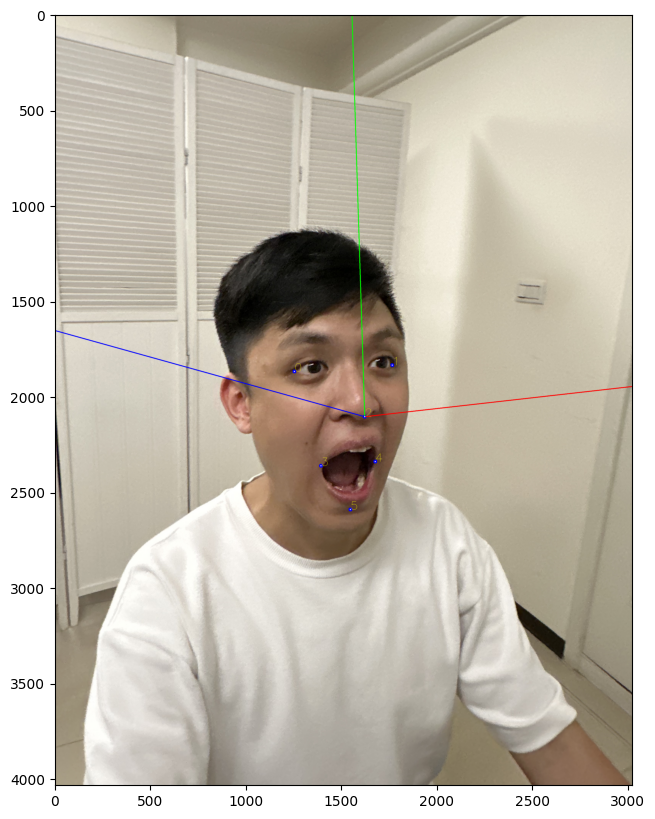

抬頭(+)/低頭(-) [pitch]:  [-5.27769195]
右轉(+)/左轉(-) [yaw]  :  [-30.29445979]
右傾(+)/左傾(-) [roll] :  [-1.87223994]


In [92]:
# 投射一個3D的點 (100.0, 0, 0)到2D圖像的座標上
(x_end_point2D, jacobian) = cv2.projectPoints(np.array([(100.0, 0.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# 投射一個3D的點 (0, 100.0, 0)到2D圖像的座標上
(y_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 100.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# 投射一個3D的點 (0, 0, 100.0)到2D圖像的座標上
(z_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 100.0)]), rotation_vector
                                           , translation_vector, camera_matrix, dist_coeffs)


# 以 Nose tip為中心點畫出x, y, z的軸線
p_nose = (int(face_points[2][0]), int(face_points[2][1]))

p_x = (int(x_end_point2D[0][0][0]), int(x_end_point2D[0][0][1]))

p_y = (int(y_end_point2D[0][0][0]), int(y_end_point2D[0][0][1]))

p_z = (int(z_end_point2D[0][0][0]), int(z_end_point2D[0][0][1]))

cv2.line(img, p_nose, p_x, (0,0,255), 3)  # X軸 (紅色)
cv2.line(img, p_nose, p_y, (0,255,0), 3)  # Y軸 (綠色)
cv2.line(img, p_nose, p_z, (255,0,0), 3)  # Z軸 (藍色)

# 把6個基準點標註出來
for p in face_points:
    cv2.circle(img, (int(p[0]), int(p[1])), 3, (255,255,255), -1)

# 秀出圖像
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,::-1]) # 從BGR -> RGB
plt.show()

print("抬頭(+)/低頭(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("右轉(+)/左轉(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("右傾(+)/左傾(-) [roll] : ", roll)  # 右傾(+)/左傾(-)


SixDRepNet

In [21]:
# Import SixDRepNet
from sixdrepnet import SixDRepNet
import cv2

# Create model
# Weights are automatically downloaded
model = SixDRepNet(dict_path='6DRepNet_300W_LP_AFLW2000.pth')

img = cv2.imread('/media/aaron/work/KIRI/ME_1015/P22_MOUTH_WIDE_OPEN/images/0048.png')

pitch, yaw, roll = model.predict(img)

model.draw_axis(img, yaw, pitch, roll)


array([[[194, 212, 223],
        [191, 209, 220],
        [186, 206, 217],
        ...,
        [136, 156, 167],
        [136, 156, 167],
        [134, 154, 165]],

       [[188, 206, 217],
        [184, 202, 213],
        [178, 198, 209],
        ...,
        [134, 154, 165],
        [134, 154, 165],
        [133, 153, 164]],

       [[183, 201, 212],
        [181, 199, 210],
        [179, 197, 208],
        ...,
        [132, 152, 163],
        [133, 153, 164],
        [134, 154, 165]],

       ...,

       [[228, 233, 236],
        [228, 233, 236],
        [228, 233, 236],
        ...,
        [106, 132, 148],
        [107, 133, 149],
        [105, 131, 147]],

       [[230, 234, 235],
        [229, 233, 234],
        [229, 233, 234],
        ...,
        [106, 132, 148],
        [109, 135, 151],
        [107, 133, 149]],

       [[230, 234, 235],
        [230, 234, 235],
        [229, 233, 234],
        ...,
        [104, 130, 146],
        [106, 132, 148],
        [104, 130, 146]]

In [22]:
cv2.imwrite('test.png', img)

True

In [20]:
pitch, yaw, roll

(array([1.7708311], dtype=float32),
 array([-1.9301577], dtype=float32),
 array([-0.0667112], dtype=float32))

In [4]:
import numpy as np
from scipy.spatial.transform import Rotation

# 定義 yaw、pitch 和 roll 的值（以弧度為單位）
yaw = yaw[0]
pitch = pitch[0]
roll = roll[0]

# 計算旋轉矩陣
rotation_matrix = Rotation.from_euler('zyx', [yaw, pitch, roll], degrees=False).as_matrix()

# 將旋轉矩陣轉換為旋轉向量
rotation_vector = Rotation.from_matrix(rotation_matrix).as_rotvec()

print("旋轉矩陣:")
print(rotation_matrix)
print("旋轉向量:")
print(rotation_vector)

旋轉矩陣:
[[ 0.06987931 -0.18601057  0.98005967]
 [-0.91106345 -0.41205332 -0.01324591]
 [ 0.40630072 -0.89197092 -0.19826143]]
旋轉向量:
[-1.68777172  1.10202181 -1.39261286]
